# 02. Comprendiendo Factores de Escala
`networkx` (o `igraph`, a tal fin) 

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import load_iris
import networkx as nx

In [19]:
from sklearn.neighbors import KernelDensity

In [20]:
from numpy import random as rnd
import seaborn as sns


In [21]:
A = rnd.rand(100, 3)
A.sort(axis=1)
A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
a = A[0]
a, A[:5,]

(array([0.        , 0.13747014, 0.16176776, 0.21681768, 1.        ]),
 array([[0.        , 0.13747014, 0.16176776, 0.21681768, 1.        ],
        [0.        , 0.30973127, 0.78220502, 0.93310863, 1.        ],
        [0.        , 0.36343099, 0.57336083, 0.58200787, 1.        ],
        [0.        , 0.18372278, 0.64448452, 0.79243908, 1.        ],
        [0.        , 0.09424641, 0.42097325, 0.87516268, 1.        ]]))

In [22]:
def fermat_dist(x, alpha=1):
    """ Fermat alpha-distance between `x_0` and `x_k`, in the line graph with nodes at `x = (x_1, ..., x_k)`."""
    return ((x[1:] - x[:-1]) ** alpha).sum()
    

In [23]:
np.apply_along_axis(fermat_dist, axis=1, arr=X, alpha=3).mean()


-49.56724

In [24]:
sample_size = 1000
scales = [1/10, 1/2, 1, 2, 10]
alphas = np.linspace(1, 4, 7)
ks = [1, 2, 5, 10]
results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for scale in scales:
        for alpha in alphas:
            results.append(
                dict(
                    k=k,
                    alpha=alpha,
                    scale=scale,
                    dists=np.apply_along_axis(
                        fermat_dist, axis=1, arr=scale * A, alpha=alpha
                    ),
                )
            )


In [25]:
df = pd.DataFrame(results)

In [26]:
df["mean_dist"] = df.dists.apply(np.mean)
df["scaled_dist"] = df.mean_dist / (df.scale ** df.alpha)

In [27]:
df.head()

,k,alpha,scale,dists,mean_dist,scaled_dist
0,1,1.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.100000,1.000000
1,1,1.5,0.1,"[0.024085998294553053, 0.025569245663161606, 0...",0.025230,0.797830
2,1,2.0,0.1,"[0.006015062163384771, 0.006864077914275903, 0...",0.006630,0.662994
3,1,2.5,0.1,"[0.001541763270979389, 0.0018931842737626072, ...",0.001792,0.566705
4,1,3.0,0.1,"[0.00040225932450771565, 0.0005296116871413854...",0.000494,0.494491


In [28]:
df[df.k == 1].pivot("alpha", "scale", "mean_dist").round(3)

scale,0.1,0.5,1.0,2.0,10.0
alpha,,,,,
1.0,0.100,0.500,1.000,2.000,10.000
1.5,0.025,0.282,0.798,2.257,25.230
2.0,0.007,0.166,0.663,2.652,66.299
2.5,0.002,0.100,0.567,3.206,179.208
3.0,0.000,0.062,0.494,3.956,494.491
3.5,0.000,0.039,0.438,4.959,1386.070
4.0,0.000,0.025,0.393,6.294,3933.587


In [29]:
df[df.k == 1].pivot("alpha", "scale", "scaled_dist").round(3)

scale,0.1,0.5,1.0,2.0,10.0
alpha,,,,,
1.0,1.000,1.000,1.000,1.000,1.000
1.5,0.798,0.798,0.798,0.798,0.798
2.0,0.663,0.663,0.663,0.663,0.663
2.5,0.567,0.567,0.567,0.567,0.567
3.0,0.494,0.494,0.494,0.494,0.494
3.5,0.438,0.438,0.438,0.438,0.438
4.0,0.393,0.393,0.393,0.393,0.393


Está claro que si $c$ es la constance de escale `scale`, las distancias de fermat escalan según $c^{-\alpha}$. Ahora, cuánto cambian con el tamaño de muestra $k$? 

Para $k=1$, se puede calcular exactamente la esperanza de la longitud del camino. Si hay un único punto entre 0 y 1 elegido al azar según $X \sim \text{Unif}(0, 1)$, entonces la longitud del camino de Fermat cuando $alpha=2$ será $E\left(X^2 + (1-X)^2\right) = 2/3$, lo cual se ve en la tabla anterior. Para $k=1$ y otros valores de $\alpha$, la expresión no será tan bella pero es computable sin mucha dificultad. Para otros valores de $k$, sin embargo, ya entran en juego la distribución de los estadísticos de orden y no me resulta para nada evidente una fórmula cerrada.

Aproximémosla. Sean $X^{(0)} = 0, X^{(k+1)} = 1$ y $X^{(i)}, i=1,\dots,k$ las v.a. que surgen de ordenar una muestra $X_i \sim_{iid} \text{Unif}(0, 1), \ i\in[k]$. Para todo $k$ se cumple que cada "segmentito de recta", $\mathbb{E}\left(X^{(i+1)}-X^{(i)}\right) = 1 / (k + 1)$. Luego, esperaríamos que 

$$
\begin{align} dist_{\alpha}^k(0, 1) &= \mathbb{E}\ \left(\sum_{i=0}^k \left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &=  \sum_{i=0}^k\ \left( \mathbb{E}\left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &\approx (???) (k + 1) \left(\frac{1}{k+1}\right)^{\alpha}
   \end{align}

$$

Pero no vale que $E(X^k) = E(X)^k$! Qué se hace en su lugar? Hay que conocer la densidad de $X^{(i+1)}-X^{(i)}$ y calcularlo? Empíricamente, veamos como cambia la distancia con $k$.

In [30]:
df[df.scale == 1].pivot("alpha", "k", "scaled_dist")

k,1,2,5,10
alpha,,,,
1.0,1.000000,1.000000,1.000000,1.000000
1.5,0.797830,0.682042,0.510034,0.388967
2.0,0.662994,0.494479,0.283550,0.168280
2.5,0.566705,0.374569,0.168105,0.079102
3.0,0.494491,0.293255,0.104783,0.039776
3.5,0.438314,0.235567,0.068001,0.021161
4.0,0.393359,0.193156,0.045621,0.011812


In [115]:
df["k_scaled_dist"] = df.scaled_dist  * ((df.k + 2) ** (df.alpha - 1))
df[df.scale == 1].assign().pivot("alpha", "k", "k_scaled_dist")

k,1,2,5,10
alpha,,,,
1.0,1.000000,1.000000,1.000000,1.000000
1.5,1.381882,1.364084,1.349422,1.347420
2.0,1.988982,1.977916,1.984852,2.019358
2.5,2.944684,2.996552,3.113348,3.288225
3.0,4.450421,4.692074,5.134387,5.727809
3.5,6.832637,7.538158,8.815721,10.555806
4.0,10.620685,12.361966,15.648029,20.411034


In [112]:
df

,k,alpha,scale,dists,mean_dist,scaled_dist
0,1,1.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.100000,1.000000
1,1,1.5,0.1,"[0.024085998294553053, 0.025569245663161606, 0...",0.025230,0.797830
2,1,2.0,0.1,"[0.006015062163384771, 0.006864077914275903, 0...",0.006630,0.662994
3,1,2.5,0.1,"[0.001541763270979389, 0.0018931842737626072, ...",0.001792,0.566705
4,1,3.0,0.1,"[0.00040225932450771565, 0.0005296116871413854...",0.000494,0.494491
...,...,...,...,...,...,...
135,10,2.0,10.0,"[18.54617072889558, 15.898502140116069, 19.500...",16.827980,0.168280
136,10,2.5,10.0,"[28.83237136865032, 21.794016379856334, 32.462...",25.014375,0.079102
137,10,3.0,10.0,"[46.9273947822912, 30.79645311730585, 57.80935...",39.776448,0.039776
138,10,3.5,10.0,"[78.59282557082142, 44.44993793148509, 107.052...",66.917279,0.021161


In [32]:
sample_size = 1000
alphas = [1.5, 1.75, 2, 2.25, 3, 4, 5]
ks = np.array([*range(1, 11), *rnd.choice(range(11, 2001), 50, replace=False)])

results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for alpha in alphas:
        results.append(
            dict(
                k=k,
                alpha=alpha,
                dists=np.apply_along_axis(
                    fermat_dist, axis=1, arr=A, alpha=alpha
                ),
            )
        )

df = pd.DataFrame(results)
df["mean_dist"] = df.dists.apply(np.mean)

KeyboardInterrupt: 

In [ ]:
df[df.k < 50].pivot("alpha", "k", "mean_dist").round(3)

k,1,2,3,4,5,6,7,8,9,10,26
alpha,,,,,,,,,,,
1.50,0.803,0.688,0.608,0.552,0.511,0.479,0.450,0.424,0.406,0.385,0.252
1.75,0.731,0.584,0.489,0.424,0.379,0.344,0.313,0.287,0.269,0.248,0.132
2.00,0.671,0.503,0.399,0.331,0.286,0.252,0.223,0.198,0.182,0.163,0.071
2.25,0.621,0.438,0.330,0.262,0.219,0.188,0.161,0.140,0.126,0.110,0.039
3.00,0.507,0.304,0.199,0.141,0.108,0.085,0.067,0.053,0.046,0.037,0.007
4.00,0.408,0.204,0.114,0.070,0.048,0.034,0.024,0.018,0.014,0.010,0.001
5.00,0.341,0.147,0.071,0.039,0.025,0.016,0.010,0.007,0.005,0.003,0.000


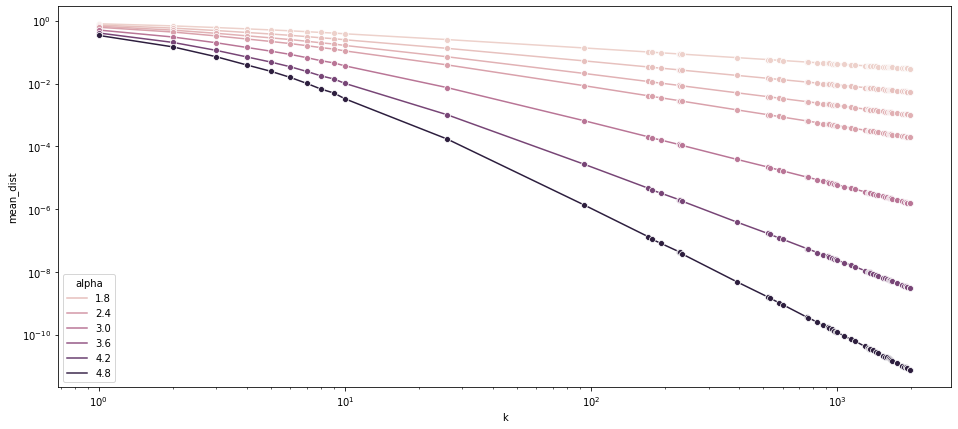

In [ ]:
plt.figure(figsize=(16, 7))
sns.lineplot(x="k", y="mean_dist", hue="alpha", data=df, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.show()

Para la elección del ancho de banda $h$ es necesario saber la escala de las distancias! Con qué se come esto???

In [ ]:
results = []
for i in range(10000):
    s = rnd.rand(100)
    s.sort()
    dists = (np.array([s[0], *(s[1:] - s[:-1]), 1 - s[-1]])) ** 2
    results.append((dists.mean(), dists.std()))

In [ ]:
np.mean([std / mean for mean, std in results])

2.0595221250271583

## Implementación KDEClassifier

In [ ]:
from scipy.stats import norm
from numpy.linalg import norm as euclidean_norm
from scipy.spatial import distance_matrix


In [34]:
import scipy
scipy.spatial.distance.minkowski(A[0], A[2])

0.5086494413404895

In [35]:
repr(fermat)

"Fermat(alpha=2, path_method='FW')"

In [36]:
B = range(5)
C = range(7)
[[b * c for c in C] for b in B]

[[0, 0, 0, 0, 0, 0, 0],
 [0, 1, 2, 3, 4, 5, 6],
 [0, 2, 4, 6, 8, 10, 12],
 [0, 3, 6, 9, 12, 15, 18],
 [0, 4, 8, 12, 16, 20, 24]]

In [37]:
(A[:] == A[2]).all(1)[:5]

array([False, False,  True, False, False])

In [38]:
A.shape, np.zeros(10)

((1000, 938), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [41]:
# WIP - ignore
def euclidean_distance(x, y):
    return euclidean_norm(x - y)


class FermatDistance(Fermat):
    def __init__(self, **kwargs):
        super.__init__(**kwargs)

    def _fit(self, X):
        self.fit(X)
        self.X_ = X
        self.n_, self.d_ = X.shape
        self.is_fitted_ = True
        return self

    def __call__(A, B):
        if self.alpha == 1:
            return distance_matrix(A, B)
        else:
            return [[self._get_distance(a, b) for a in A] for b in B]

    def _get_distance(a, b):
        if not self.is_fitted_:
            self._fit()
        if any((self.X_[:] == a).all(1)):  # `a` is a node from X_
            to_X = np.zeros(self.n_)
        else:
            to_X = euclidean_distances(a.reshape(1, -1), verts)[0] ** self.alpha

        if a_known := np.where((X[:] == 2 * X[2]).all(1)):
            to_nodes = euclidean_distances(a.reshape(1, -1), verts)[0] ** alpha


In [49]:
norm_pdf = scipy.stats.norm.pdf

class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [52]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y#, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.special import softmax


class EuclideanKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: EuclideanKDE(self.kernel, self.bandwith).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [54]:
class FermatKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        self.fermat_ = Fermat(self.alpha, self.path_method).fit(distance_matrix(X, X))
        self.distances_ = self.fermat_.get_distances()
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            self.distances(X) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities

    def distances(self, X):
        distances_to_X = distance_matrix(X, self.X_) ** self.alpha
        return np.vstack([(d + self.distances_).min(axis=1) for d in distances_to_X])


In [55]:
from scipy.special import softmax


class FermatKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: FermatKDE(
                self.kernel, self.bandwith, self.alpha, self.path_method
            ).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [57]:
A = np.array([[i] * 2 for i in range(3)])
Fermat(2, "FW").fit(distance_matrix(A, A)).get_distances()

array([[0., 2., 4.],
       [2., 0., 2.],
       [4., 2., 0.]])

In [58]:
B = np.vstack([[-1, 0], [1, 0]])
B

array([[-1,  0],
       [ 1,  0]])

In [59]:
C = np.vstack([A, B])

In [60]:
full = Fermat(2, "FW").fit(distance_matrix(C, C))
full_dists = full.get_distances()

In [61]:
n_train = 120
train = FermatKDE(2, "FW").fit(A)
test_dists = train.distances(B)

In [62]:
full_dists, test_dists

(array([[0., 2., 4., 1., 1.],
        [2., 0., 2., 3., 1.],
        [4., 2., 0., 5., 3.],
        [1., 3., 5., 0., 2.],
        [1., 1., 3., 2., 0.]]),
 array([[1., 3., 5.],
        [1., 1., 3.]]))

In [63]:
full = Fermat(2, "FW").fit(distance_matrix(X, X))
full_dists = full.get_distances()

In [64]:
n_train = 120
train = FermatKDE(2, "FW").fit(X[:n_train])
test_dists = train.distances(X[n_train:])

In [71]:
np.where(full_dists[n_train:,:n_train] > test_dists + 0.001)

(array([22]), array([101]))

In [ ]:
full_dists[n_train:,:n_train][22, 101],  test_dists[22, 101]

(0.1399999999999999, 0.0)

In [72]:
pd.Series((full_dists[n_train:,:n_train] - test_dists).flatten()).describe()

count    3.600000e+03
mean    -7.726667e-02
std      7.876425e-02
min     -4.600000e-01
25%     -1.200000e-01
50%     -6.000000e-02
75%     -4.440892e-16
max      1.400000e-01
dtype: float64

In [75]:
# Fermat distnaces between train obss, with X=train osbs, must be >= than
#   Fermat distances bw train obss, with X=(train obss + test obss)
assert (train.distances_ >= full_dists[:n_train, :n_train]).all() 

```python
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())
```

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [91]:
.shape

(898, 74)

In [108]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.90)
eucclf = EuclideanKDEClassifier().fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=200).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train)


In [109]:
for clf in [eucclf, fmtclf, rfclf]:
    print(repr(clf), ": ", accuracy_score(clf.predict(X_test), y_test))
print(repr(rfclf2), " - enhanced: ", accuracy_score(rfclf2.predict(np.concatenate([X_test, fmtclf.decision_function(X_test)], axis=1)), y_test))

/tmp/ipykernel_56471/1728847503.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


EuclideanKDEClassifier() :  0.9363411619283065
FermatKDEClassifier(bandwith=200) :  0.9400494437577256
RandomForestClassifier() :  0.907292954264524
RandomForestClassifier()  - enhanced:  0.934487021013597


In [287]:
accuracy_score(eucclf.predict(X_test), y_test), accuracy_score(fmtclf.predict(X_test), y_test)

/tmp/ipykernel_206930/2399770987.py:24: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


(0.8666666666666667, 0.8333333333333334)

In [325]:
[x.shape for x in [X_train, X_test, y_train, y_test]]

[(35, 64), (1762, 64), (35,), (1762,)]

In [141]:
sp_softmax(D * 10, axis=1).round(3)

array([[0.   , 1.   , 0.   ],
       [0.   , 0.9  , 0.1  ],
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 0.997, 0.003],
       [0.   , 0.001, 0.999],
       [1.   , 0.   , 0.   ],
       [0.   , 0.435, 0.565],
       [1.   , 0.   , 0.   ],
       [0.   , 0.021, 0.979],
       [0.   , 0.001, 0.999],
       [0.   , 0.637, 0.363],
       [0.   , 0.146, 0.854],
       [1.   , 0.   , 0.   ],
       [0.   , 0.001, 0.999],
       [1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 0.815, 0.185],
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 1.   ],
       [0.   , 0.506, 0.494],
       [0.   , 0.   , 1.   ],
       [0.   , 1.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.   , 0.992, 0.008],
       [1.   , 0.   , 0.   ],
       [0.   , 0.841, 0.159],
       [1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   ],
       [0.   , 1.   , 0.   ]])

In [136]:
(np.argmax(preds, axis=1) == y_test).mean()

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
X, y = load_iris(return_X_y=True)
N = len(X)  # # observaciones
K = len(set(y))  # # clases

In [ ]:
kde = KDEstimator()

In [ ]:
kde.fit(X[y == 0])

In [ ]:
kde.predict(X[-1])

0.00011495190242781194

In [ ]:
y[0]

0

## TemplateClassifier

In [58]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
class TemplateClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]


In [ ]:
unique_labels()